In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os
import json
import re
from collections import defaultdict
import itertools

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import datetime

# Data pre-processing

In [2]:
# df_movies = pd.read_csv('dataset/tmdb_5000_movies.csv')
# df_movies = df_movies.dropna(subset=['overview', 'release_date', 'runtime'])
# df_movies.isnull().sum()
# df_movies.to_csv("dataset/tmdb_5000_movies_nonull.csv")

## Load two datasets and merge them by movie_id

In [3]:
df = pd.read_csv('dataset/tmdb_5000_movies_nonull.csv')
# df_movies.loc[:,['id', 'keywords', 'genres', 'title']]
df_credits = pd.read_csv('dataset/tmdb_5000_credits.csv')
credits_sub = df_credits.loc[:, ['movie_id', 'cast']].rename(columns={
                                                             'movie_id': 'id'})

df = df[['id', 'budget', 'genres', 'keywords', 'original_language',
         'overview', 'popularity', 'production_companies',
         'production_countries', 'release_date', 'revenue', 'runtime',
         'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count']]
df = df.merge(credits_sub)

# df.sort_values(by='release_date', ascending=False).head(10)

In [4]:
df.shape

(4799, 18)

## Add subtitles (US movies only)

In [5]:
with open('dataset/subtitles/subtitles.json', 'r') as f:
    sub_dict = json.load(f)
sub_dict = defaultdict(str, sub_dict)

In [6]:
# df["subtitles"] = df.title.apply(lambda title: sub_dict[title]) # keep blocks separated
df["subtitles"] = df.title.apply(
    lambda title: "\n\n".join(sub_dict[title]))  # single string

In [7]:
df[df["subtitles"] == ''].shape

(1359, 19)

In [8]:
df.head(10)

,id,budget,genres,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,cast,subtitles
0,19995,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","When I was lying there\nin the VA hospital,\n\..."
1,285,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[man] ""ln order to affect a timely halt\nto de..."
2,206647,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...",Where are you going?\n\nI won't be long.\n\nWe...
3,49026,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...",I knew Harvey Dent.\n\nI was his friend.\n\nAn...
4,49529,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...",Subtitles downloaded from Podnapisi.NET\n\nMar...
5,559,258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...","[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-01,890871626,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",The battle within.,Spider-Man 3,5.9,3576,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...",
6,38757,260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...","[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",en,When the kingdom's most wanted-and most charmi...,48.681969,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2010-11-24,591794936,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",They're taking adventure to new lengths.

## Drop movies with no genres information

In [9]:
# drop movies with no genre info
for i, row in df.iterrows():
    if row['genres'] == '[]':
        df.drop(i, inplace=True)
df = df.dropna()

In [10]:
all_genres = defaultdict(int)

for row in df.genres:
    for item in json.loads(row):
        #         print(item)
        all_genres[item['name']] += 1

genres_list = sorted(all_genres.items(), key=lambda x: x[1], reverse=True)
genres_list

[('Drama', 1801),
 ('Comedy', 1442),
 ('Thriller', 1151),
 ('Action', 1025),
 ('Romance', 726),
 ('Adventure', 720),
 ('Crime', 627),
 ('Science Fiction', 488),
 ('Horror', 470),
 ('Family', 437),
 ('Fantasy', 388),
 ('Mystery', 316),
 ('Animation', 201),
 ('History', 153),
 ('Music', 149),
 ('War', 115),
 ('Western', 69),
 ('Documentary', 56),
 ('Foreign', 14),
 ('TV Movie', 3)]

## Column transformation

**Steps:**  
+ Filter columns with specific filtering values
+ Convert json-format cells to list
+ Extract cast gender and calculate the proportion of female cast and male cast for each movie

In [11]:
def convert_list(cell):
    """convert the json format to a list of categories"""
    kw_list = []
    for kw in json.loads(cell):
        kw_list.append(kw['name'])
    return kw_list


def larger_n(col, n):
    """filter the column"""
    keywords = defaultdict(int)
    for row in df[col]:
        row = json.loads(row)
        for entry in row:
            keywords[entry['name']] += 1
    kw_cnt = sorted(keywords.items(), key=lambda x: -x[1])
    return [kw[0] for kw in kw_cnt if kw[1] >= n]


def extract_gender(cell):
    """Extract cast gender"""
    female = 0
    male = 0
    for item in json.loads(cell):
        if item['gender'] == 1:
            female += 1
        elif item['gender'] == 2:
            male += 1
        else:
            continue
    return female, male


def concat_names(cell):
    """Concatenate first names and last names"""
    names = []
    for name in cell:
        names.append(name.replace(' ', ''))
    return names


def list2str(cell):
    """Convert list to string"""
    return ' '.join(cell)


def transform_cols(df, cols_to_transform):
    """Transform columns of a dataframe.
    cols_to_transform should be a dict(col_name: filter value n)
    """
    for col_name in cols_to_transform.keys():
        larger_col = larger_n(col_name, cols_to_transform[col_name])
        if col_name == 'cast':
            gen = df[col_name].apply(extract_gender)
            df['female_pct'] = gen.apply(lambda x: x[0]/(x[0]+x[1]+0.001))
            df['male_pct'] = gen.apply(lambda x: x[1]/(x[0]+x[1]+0.001))

        df[col_name] = df[col_name].apply(convert_list)\
            .apply(lambda cell: [kw for kw in cell if kw in larger_col])
    return df


def tokenize(text):
    """
    A tokenizer, remove special characters punctuation and replace them with a space, stem the word
    """
    text = text.lower()
    cleanString = re.sub('[^a-zA-Z]', ' ', text)
    words = nltk.word_tokenize(cleanString)
    english = list(ENGLISH_STOP_WORDS)
    goodwords = [w for w in words if w not in english]
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in goodwords]
    return stemmed

In [12]:
cols_to_transform = {'keywords': 30,
                     'genres': 0,
                     'production_companies': 5,
                     'production_countries': 3,
                     'spoken_languages': 10,
                     'cast': 2}

df_movies = transform_cols(df, cols_to_transform)

In [13]:
# use only movies with subtitles
df_movies = df_movies[df_movies["subtitles"] != '']
df_movies = df_movies.reset_index(drop=True)
df_movies.shape

(3037, 21)

# Feature Engineering

## Runtime - drop 0 runtime

In [14]:
df_movies.loc[df_movies.runtime == 0]

,id,budget,genres,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,...,runtime,spoken_languages,tagline,title,vote_average,vote_count,cast,subtitles,female_pct,male_pct
2966,285743,0,"[Music, Horror]","[musical, sequel]",en,The Devil's Carnival: Alleluia! is the second ...,0.674398,[],[United States of America],2016-03-29,...,0.0,[],Hell ain't got a prayer.,Alleluia! The Devil's Carnival,6.0,2,"[Terrance Zdunich, Paul Sorvino, Nivek Ogre, A...",Advertise your product or brand here\ncontact ...,0.363603,0.636306


Checking the movies that have no runtime data, we can see that these six movies also lack revenue data, production companies, keywords, and all have very few vote counts. So we can think that removing these six rows will not have significant influence on our model.  

In [15]:
df_movies = df_movies.drop(df_movies.loc[df_movies.runtime == 0].index)

In [16]:
df_movies = df_movies.reset_index(drop=True)

## Overview

### TfidfVectorizer

In [17]:
import re
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.porter import *

In [18]:
df_movies = df_movies.loc[df_movies.overview.apply(lambda x: len(x) > 10)]
# df_movies = df_movies.reset_index(drop=True)

tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english', binary=True,
                        ngram_range=(1, 1), min_df=0.001)
overview_vec = tfidf.fit_transform(df_movies['overview'])

overview_docvecs = pd.DataFrame(overview_vec.toarray(
), columns=tfidf.get_feature_names()).add_prefix('ov_')
# overview_vec = overview_vec.todense()

### Doc2vec

## Subtitles -- Word2Vec

### Tfidf

Tfidf-ing all the subtitles will take some time. Be prapared when you run it!

In [38]:
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english', binary=True,
                        ngram_range=(1, 1), min_df=0.001)
subtitles_vec = tfidf.fit_transform(df_movies['subtitles'])
subtitles = pd.DataFrame(subtitles_vec.toarray(
), columns=tfidf.get_feature_names()).add_prefix('sub_')

In [39]:
subtitles.head(5)

,sub_aa,sub_aaa,sub_aaaa,sub_aaaaaah,sub_aaaaah,sub_aaaah,sub_aaaargh,sub_aaagh,sub_aaah,sub_aaahh,...,sub_zullen,sub_zulu,sub_zumba,sub_zur,sub_zurich,sub_zvu,sub_zwei,sub_zy,sub_zz,sub_zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Doc2Vec

In [27]:
def text_to_words(text):
    # remove punctuation and whitespace
    # but keep hyphens and apostrophes
    filtered_text = re.sub(r'[^\w\'\s-]',
                           '', text)
    return word_tokenize(filtered_text.lower())

In [28]:
idxs = df_movies.id.tolist()
%time sub_words = [text_to_words(text) for text in df_movies.subtitles.tolist()]
subs = dict(zip(idxs, sub_words))

CPU times: user 1min 20s, sys: 1.46 s, total: 1min 21s
Wall time: 1min 22s


In [29]:
%time tagged_data = [TaggedDocument(words=word_list, tags=[index]) for index, word_list in subs.items()]

CPU times: user 395 ms, sys: 566 ms, total: 961 ms
Wall time: 956 ms


#### Model 1: not pretrained

In [30]:
model = Doc2Vec(vector_size=50, min_count=2, workers=4)
%time model.build_vocab(tagged_data)

CPU times: user 11.7 s, sys: 1.06 s, total: 12.8 s
Wall time: 13.4 s


In [31]:
%time model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 3min 4s, sys: 1.46 s, total: 3min 5s
Wall time: 52.1 s


#### Model 2: using pretrained word2vec weights

In [32]:
# download glove.6B.50d.txt from
# https://www.kaggle.com/rtatman/glove-global-vectors-for-word-representation/version/1
# run following command to convert to word2vec format (extra line at the top)
# python -m gensim.scripts.glove2word2vec -i glove.6B.50d.txt -o glove.6B.50d.word2vec.txt
# https://github.com/RaRe-Technologies/gensim/blob/4543646d3fe3496e11bc935e72cbf9b18504442e/gensim/models/word2vec.py

In [33]:
word2vec = Word2Vec(size=50)
%time word2vec.build_vocab([word for text in tagged_data for word in text])

CPU times: user 5.75 s, sys: 42.2 ms, total: 5.79 s
Wall time: 5.81 s


In [34]:
# lockf=0 doesn't train word vectors any further, 1.0 does.
# glove_path = "/Users/xhan/OneDrive/dataset/glove/glove.6B.50d.word2vec.txt"
glove_path = "/Users/weiwei/data/glove/glove.6B.50d.word2vec.txt"
%time word2vec.intersect_word2vec_format(glove_path, lockf=1.0, binary=False, encoding='utf8', unicode_errors='strict')

CPU times: user 12.6 s, sys: 64.1 ms, total: 12.7 s
Wall time: 12.7 s


In [35]:
model_pretrained = Doc2Vec(vector_size=50, min_count=2, workers=4)
model_pretrained.build_vocab(tagged_data)
model_pretrained.wv = word2vec.wv
%time model_pretrained.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 2min 56s, sys: 1.21 s, total: 2min 57s
Wall time: 49.6 s


In [36]:
def infer_docvecs(df):
    docvecs = []
    for index in tqdm(df.id.tolist()):
        word_list = subs[index]
        vec = model_pretrained.infer_vector(word_list, steps=20)
        docvecs.append(vec)
    docvecs = np.array(docvecs, dtype=np.float32)
    return docvecs

In [37]:
movies_docvecs = infer_docvecs(df_movies)
movies_docvecs.shape

100%|██████████| 3036/3036 [09:02<00:00,  5.60it/s]


(3036, 50)

## Cast names -- CountVectorizer

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# concatenate names and join the list of names to a string
df_movies['cast'] = df_movies['cast'].apply(concat_names).apply(list2str)

vectorizer = CountVectorizer(ngram_range=(1, 1))
cast_vect = vectorizer.fit_transform(df_movies['cast'])

cast = pd.DataFrame(cast_vect.todense(),
                    columns=vectorizer.get_feature_names()).add_prefix('cast_')

## Budget + Revenue -- deal with abnormal values

There are some movies in the data set has less than $100 budget, which obviously does not make any sense. So we need to deal with these abnormal values.

In [20]:
# number of movies with less than $100 budget
df_movies.loc[(df_movies.budget < 100)].shape[0]

343

For these 107 movies with less than \\$100 budget and more than \\$10000 revenue, we use `revenue + overview + popularity + release_date` to predict the actual budget.

In [21]:
df_movies.loc[(df_movies.budget < 100) & (df_movies.revenue > 10000)].shape

(72, 21)

In [22]:
from sklearn import ensemble


def predict_budget1(dataset):
    """Predict budget of movies with less than $100 budget and more than $10000 revenue"""
    data_p = dataset[['revenue', 'popularity', 'budget']]
    data_p = pd.concat([data_p, overview_docvecs], axis=1)

    x_train = data_p.loc[~(data_p.budget < 100) & (
        data_p.revenue > 10000)].drop('budget', 1)
    y_train = data_p.loc[~(data_p.budget < 100) &
                         (data_p.revenue > 10000)]['budget']
    x_test = data_p.loc[(data_p.budget < 100) & (
        data_p.revenue > 10000)].drop('budget', 1)

    rfr = ensemble.RandomForestRegressor(random_state=42)
    rfr.fit(x_train, y_train)

    y_test = rfr.predict(x_test)
    return y_test


df_movies.loc[(df_movies.budget < 100) &
              (df_movies.revenue > 10000), 'budget'] = predict_budget1(df_movies)

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [23]:
# check
df_movies.loc[(df_movies.budget < 100) & (df_movies.revenue > 10000)].shape

(0, 21)

For others whose revenue are below $10000, use `overview + popularity + release_date` to predict budget

In [24]:
df_movies.loc[(df_movies.budget < 100)].shape

(271, 21)

In [25]:
def predict_budget2(dataset):
    """Predict budget of movies with less than $100 budget and less than $10000 revenue"""
    data_p = dataset[['popularity', 'budget']]
    data_p = pd.concat([data_p, overview_docvecs], axis=1)

    x_train = data_p.loc[~(data_p.budget < 100)].drop('budget', 1)
    y_train = data_p.loc[~(data_p.budget < 100)]['budget']
    x_test = data_p.loc[(data_p.budget < 100) & (
        df_movies.revenue <= 10000)].drop('budget', 1)

    rfr = ensemble.RandomForestRegressor(random_state=42)
    rfr.fit(x_train, y_train)
#     print(x_test.shape)
    y_test = rfr.predict(x_test)
    return y_test


df_movies.loc[(df_movies.budget < 100) & (df_movies.revenue <=
                                          10000), 'budget'] = predict_budget2(df_movies)

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [26]:
df_movies.loc[(df_movies.budget < 100)].shape

(0, 21)

## Keywords + tagline

Maybe we should not use tagline as a feature, two reasons:  
+ tagline is too short for each movie, and has almost no overlap across movies
+ Even, as a human, I cannot have a good guess of the movie genres reading only the tagline when I already know the movie.

In [27]:
# check all keywords and their count
kw_all = defaultdict(int)

for cell in df_movies.keywords:
    for kw in cell:
        kw_all[kw] += 1

print(len(kw_all))
sorted(kw_all.items(), key=lambda x: x[1], reverse=True)

124


[('duringcreditsstinger', 252),
 ('woman director', 182),
 ('independent film', 155),
 ('based on novel', 146),
 ('aftercreditsstinger', 138),
 ('murder', 136),
 ('violence', 111),
 ('dystopia', 109),
 ('revenge', 89),
 ('sport', 86),
 ('3d', 81),
 ('sequel', 79),
 ('friendship', 78),
 ('teenager', 74),
 ('sex', 73),
 ('musical', 70),
 ('suspense', 67),
 ('los angeles', 66),
 ('love', 63),
 ('new york', 62),
 ('high school', 62),
 ('alien', 60),
 ('superhero', 59),
 ('biography', 58),
 ('family', 54),
 ('police', 53),
 ('remake', 50),
 ('prison', 48),
 ('nudity', 48),
 ('drug', 48),
 ('based on comic book', 47),
 ('dying and death', 47),
 ('corruption', 46),
 ('serial killer', 46),
 ('airplane', 43),
 ('wedding', 43),
 ('magic', 42),
 ('father son relationship', 42),
 ('fbi', 42),
 ('friends', 41),
 ('london england', 41),
 ('daughter', 40),
 ('time travel', 40),
 ('party', 40),
 ('lawyer', 39),
 ('based on young adult novel', 38),
 ('cia', 38),
 ('brother brother relationship', 37),
 

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

keywords_dummies = pd.DataFrame(mlb.fit_transform(
    df_movies['keywords']), columns=mlb.classes_).add_prefix('kw_')

## production_companies

In [29]:
prod_com = pd.DataFrame(mlb.fit_transform(
    df_movies['production_companies']), columns=mlb.classes_).add_prefix('prodComp_')

## production_countries

In [30]:
prod_coun = pd.DataFrame(mlb.fit_transform(
    df_movies['production_countries']), columns=mlb.classes_).add_prefix('prodComp_')

## release_date

In [31]:
# df_movies['year_bucket'] =
years = pd.get_dummies(df_movies.apply(
    lambda row: str(row.release_date)[:3], axis=1))
years['before97'] = years.iloc[:, :6].sum(axis=1)
years = years.iloc[:, 6:]

## popularity + vote_average + vote_count

In [32]:
# df_movies.loc[df_movies['vote_average']!=0].vote_average.mean()
df_movies.loc[df_movies['vote_average'] == 0,
              'vote_average'] = df_movies.loc[df_movies['vote_average'] != 0].vote_average.mean()
df_movies.loc[df_movies['vote_count'] == 0,
              'vote_count'] = df_movies.loc[df_movies['vote_count'] != 0].vote_count.mean()

# Result-dataset

In [79]:
df_movies = df_movies.reset_index(drop=True)

In [80]:
df_movies.columns

Index(['id', 'budget', 'genres', 'keywords', 'original_language', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'tagline',
       'title', 'vote_average', 'vote_count', 'cast', 'subtitles',
       'female_pct', 'male_pct'],
      dtype='object')

Besides the modified dataframe, we also have three vectorized features: overview, cast names, and keywords.  


**Features** (so far ready to use):  
+ **numeric**: budget, revenue, female_pct, male_pct, runtime 
+ **text(vectorized)**: keywords, overview, cast(names)

**Labels**:  
20 genres, i.e., `genre_*`

In [81]:
# labels
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genres_dummies = pd.DataFrame(mlb.fit_transform(
    df_movies['genres']), columns=mlb.classes_).add_prefix('genre_')

In [82]:
df_movies.head(5)

,id,budget,genres,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,...,runtime,spoken_languages,tagline,title,vote_average,vote_count,cast,subtitles,female_pct,male_pct
0,19995,237000000.0,"[Action, Adventure, Fantasy, Science Fiction]","[future, alien, soldier, 3d]",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,...,162.0,"[English, Español]",Enter the World of Pandora.,Avatar,7.2,11800.0,SamWorthington ZoeSaldana SigourneyWeaver Step...,"When I was lying there\nin the VA hospital,\n\...",0.374988,0.624980
1,285,300000000.0,"[Adventure, Fantasy, Action]","[love of one's life, aftercreditsstinger]",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films]",[United States of America],2007-05-19,...,169.0,[English],"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500.0,JohnnyDepp OrlandoBloom KeiraKnightley Stellan...,"[man] ""ln order to affect a timely halt\nto de...",0.166661,0.833306
2,206647,245000000.0,"[Action, Adventure, Crime]","[spy, based on novel, sequel]",en,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq]","[United Kingdom, United States of America]",2015-10-26,...,148.0,"[Français, English, Español, Italiano, Deutsch]",A Plan No One Escapes,Spectre,6.3,4466.0,DanielCraig ChristophWaltz LéaSeydoux RalphFie...,Where are you going?\n\nI won't be long.\n\nWe...,0.191174,0.808812
3,49026,250000000.0,"[Action, Crime, Drama, Thriller]","[terrorist, secret identity, superhero]",en,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012-07-16,...,165.0,[English],The Legend Ends,The Dark Knight Rises,7.6,9106.0,ChristianBale MichaelCaine GaryOldman AnneHath...,I knew Harvey Dent.\n\nI was his friend.\n\nAn...,0.130951,0.869037
4,49529,260000000.0,"[Action, Adventure, Science Fiction]","[based on novel, alien, escape, 3d]",en,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],[United States of America],2012-03-07,...,132.0,[English],"Lost in our world, found in another.",John Carter,6.1,2124.0,TaylorKitsch LynnCollins SamanthaMorton Willem...,Subtitles downloaded from Podnapisi.NET\n\nMar...,0.239990,0.759970


In [83]:
# features (subtitles tfidf)
features = pd.concat((df_movies.loc[:, ["release_date", 'budget', 'revenue', 'female_pct', 'male_pct', 'runtime',
                                        'vote_average', 'vote_count']],
                      overview_docvecs, cast, keywords_dummies, prod_com, prod_coun, years, subtitles), axis=1)

In [84]:
features.shape

(3036, 47842)

## Drop Labels: Foreign and TV Movie

In [85]:
genres_dummies = genres_dummies.drop(
    ['genre_Foreign', 'genre_TV Movie'], axis=1)
genres_dummies.shape

(3036, 18)

In [86]:
genres_dummies.sum(axis=0).sort_values()

genre_Documentary          34
genre_Western              49
genre_War                  84
genre_History              97
genre_Music               118
genre_Animation           157
genre_Mystery             251
genre_Fantasy             317
genre_Family              356
genre_Horror              367
genre_Science Fiction     383
genre_Crime               474
genre_Romance             550
genre_Adventure           585
genre_Action              810
genre_Thriller            896
genre_Comedy             1143
genre_Drama              1317
dtype: int64

In [66]:
genres_dummies.to_csv("dataset/genres_dummies.csv", index=False)
features.to_csv("dataset/features.csv", index=False)

# Modelling

The result is very interesting.  

When I use only cast names and gender proportion, the prediction tends to give less genres for each movie than the ground truth (please refer to the `cast_vs_genres` notebook); however, using the eight features I mentioned above, the model tends to give more genres than the ground truth.

## Split train/test sets according to release date (to better stratify the data)

Split the data using time. train_data: before 2012-01-01; test_data: after 2012-01-01.   
The proportion is about 0.8:0.2.   

In [87]:
features.release_date = pd.to_datetime(features.release_date)
# df.release_date.max(), df.release_date.min()
split_date = datetime.datetime(2012, 1, 1)
train_data = features[features.release_date < split_date]
test_data = features[features.release_date >= split_date]
train_labels = genres_dummies[features.release_date < split_date]
test_labels = genres_dummies[features.release_date >= split_date]

# train_data.shape[0]/features.shape[0], test_data.shape[0]/features.shape[0]
train_data.drop(["release_date"], axis=1, inplace=True)
test_data.drop(["release_date"], axis=1, inplace=True)

In [89]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## GridSearchCV on Random Forest

In [ ]:
# from xgboost import XGBClassifier

rf = OneVsRestClassifier(RandomForestClassifier())
grid_params = {
    "estimator__n_estimators": range(10, 100, 2),
    "estimator__max_features": range(30, 300, 2),
    "estimator__min_samples_leaf": range(1, 10, 2)
    #     ,"estimator__oob_score": [True, False]
}
gs = GridSearchCV(estimator=rf,
                  param_grid=grid_params,
                  #                     scoring='recall',
                  verbose=5,
                  n_jobs=4,
                  cv=5)

gs.fit(train_data, train_labels)
predictions = gs.predict(test_data)

In [90]:
rf_best = OneVsRestClassifier(RandomForestClassifier(
    max_features=1000, n_estimators=100))
rf_best.fit(train_data, train_labels)
predictions = rf_best.predict(test_data)

In [91]:
accuracy = accuracy_score(y_pred=predictions, y_true=np.array(test_labels))
f1 = f1_score(y_pred=predictions, y_true=np.array(
    test_labels), average='weighted')
precision = precision_score(
    y_pred=predictions, y_true=np.array(test_labels), average='weighted')
recall = recall_score(y_pred=predictions, y_true=np.array(
    test_labels), average='weighted')

print("Subset Accuracy: {}".format(accuracy))  # subset accuracy
print("Global F1 score: {}".format(f1))
print("Global Precision: {}".format(precision))
print("Global Recall: {}".format(recall))

Subset Accuracy: 0.13270142180094788
Global F1 score: 0.41005603507737853
Global Precision: 0.7550775394053469
Global Recall: 0.31511254019292606


/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [94]:
classes = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
           'Documentary', 'Drama', 'Family', 'Fantasy', 'History',
           'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
           'Thriller', 'War', 'Western']

In [95]:
print(classification_report(test_labels, predictions, target_names=classes))

                 precision    recall  f1-score   support

         Action       0.85      0.33      0.48       176
      Adventure       0.84      0.26      0.39       125
      Animation       1.00      0.12      0.22        41
         Comedy       0.75      0.68      0.71       202
          Crime       0.60      0.03      0.06        92
    Documentary       0.00      0.00      0.00         7
          Drama       0.75      0.43      0.55       259
         Family       0.92      0.35      0.51        65
        Fantasy       0.88      0.11      0.19        65
        History       0.00      0.00      0.00        15
         Horror       0.67      0.05      0.09        82
          Music       0.00      0.00      0.00        24
        Mystery       0.00      0.00      0.00        35
        Romance       1.00      0.04      0.08        72
Science Fiction       0.91      0.35      0.50        83
       Thriller       0.82      0.40      0.54       193
            War       0.00    

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', ave

In [96]:
from sklearn.metrics import hamming_loss

train_predictions = rf_best.predict(train_data)

print(f"Train Hamming Loss: {hamming_loss(train_labels, train_predictions)}\n")
print(f"Test Hamming Loss: {hamming_loss(test_labels, predictions)}\n")

Train Hamming Loss: 0.0

Test Hamming Loss: 0.10452869931542917



## MultinomialNB()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
# Result using MultinomialNB()
clf = OneVsRestClassifier(MultinomialNB(alpha=1.0))
clf.fit(train_data, train_labels)
predictions = clf.predict(test_data)

In [97]:
accuracy = accuracy_score(y_pred=predictions, y_true=np.array(test_labels))
f1 = f1_score(y_pred=predictions, y_true=np.array(
    test_labels), average='weighted')
precision = precision_score(
    y_pred=predictions, y_true=np.array(test_labels), average='weighted')
recall = recall_score(y_pred=predictions, y_true=np.array(
    test_labels), average='weighted')

print("Subset Accuracy: {}".format(accuracy))  # subset accuracy
print("Global F1 score: {}".format(f1))
print("Global Precision: {}".format(precision))
print("Global Recall: {}".format(recall))

Subset Accuracy: 0.13270142180094788
Global F1 score: 0.5742817782855275
Global Precision: 0.5333465064828578
Global Recall: 0.6295819935691318


In [99]:
# Result using MultinomialNB()
print(classification_report(test_labels, predictions, target_names=classes))

                 precision    recall  f1-score   support

         Action       0.66      0.79      0.72       176
      Adventure       0.62      0.78      0.69       125
      Animation       0.27      0.22      0.24        41
         Comedy       0.66      0.85      0.74       202
          Crime       0.52      0.47      0.49        92
    Documentary       0.00      0.00      0.00         7
          Drama       0.67      0.75      0.71       259
         Family       0.52      0.62      0.56        65
        Fantasy       0.39      0.43      0.41        65
        History       0.10      0.13      0.11        15
         Horror       0.33      0.21      0.25        82
          Music       0.06      0.04      0.05        24
        Mystery       0.11      0.11      0.11        35
        Romance       0.40      0.65      0.50        72
Science Fiction       0.48      0.63      0.54        83
       Thriller       0.56      0.67      0.61       193
            War       0.12    

/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [100]:
train_predictions = clf.predict(train_data)

print(f"Train Hamming Loss: {hamming_loss(train_labels, train_predictions)}\n")
print(f"Test Hamming Loss: {hamming_loss(test_labels, predictions)}\n")

Train Hamming Loss: 0.043117399546862716

Test Hamming Loss: 0.1240126382306477



# Visualize predicted genres

In [128]:
def undummy_genres(genres_dummies):
    """Match dummy-ized predictions with genres."""
    genres = []
    total_num_genres = genres_dummies.sum(axis=0)
    for row in genres_dummies:
        indices = [i for i, x in enumerate(row) if x == 1]
        genres.append([classes[i] for i in indices])

    return genres, total_num_genres


def list2pairs(genres_list):
    """Create a list of paired genres"""
    pairs_list = []
    for genres in genres_list:
        for pair in list(itertools.combinations(genres, 2)):
            pairs_list.append(pair)

    return pairs_list


def create_visGrid(classes, genres_list):
    """Create a grid of pair counts."""
    all_pairs = list(itertools.combinations(classes, 2))
    pairs_list = list2pairs(genres_list)

    nr_ids = np.unique(all_pairs)
    visGrid = np.zeros((len(nr_ids), len(nr_ids)))
    for p in pairs_list:
        visGrid[np.argwhere(nr_ids == p[0]), np.argwhere(nr_ids == p[1])] += 1
        if p[1] != p[0]:
            visGrid[np.argwhere(nr_ids == p[1]),
                    np.argwhere(nr_ids == p[0])] += 1
    visGrid = visGrid.astype(int)

    return nr_ids, visGrid


def make_heatmap(nr_ids, visGrid, ax=None, cbar=True, cbar_size=1.0):
    # shows how often the genres occur together
    annot_lookup = []
    for i in range(len(nr_ids)):
        annot_lookup.append(nr_ids[i])

    # create mask
    mask = np.zeros_like(visGrid)
    mask[np.triu_indices_from(mask)] = True

    # make the heatmap
    sns.set(rc={'figure.figsize': (10, 8)})
    with sns.axes_style("white"):
        sns.heatmap(visGrid, mask=mask, square=True, vmin=0, vmax=visGrid.max(),
                    xticklabels=annot_lookup, yticklabels=annot_lookup, ax=ax, cbar=cbar,
                    cbar_kws={"shrink": cbar_size})

## Heatmap (Tfidf for both)

### Genres pair occurence heatmap - predicted genres

In [116]:
pred_classes, pred_num_genres = undummy_genres(predictions)
nr_ids, visGrid_pred = create_visGrid(classes, pred_classes)

In [122]:
pred_num_genres

array([211, 159,  33, 261,  83,  15, 291,  77,  71,  20,  52,  17,  37,
       117, 108, 233,  16,  15])

### Genres pair occurence heatmap - test labels

In [117]:
gt_classes, test_num_genres = undummy_genres(test_labels.values)
nr_ids, visGrid_gt = create_visGrid(classes, gt_classes)

### Genres pair occurence heatmap - train labels

In [106]:
train_labels_notdummy, train_num_genres = undummy_genres(
    np.asarray(train_labels))
nr_ids, visGrid_train = create_visGrid(classes, train_labels_notdummy)

### Genres pair occurence heatmap

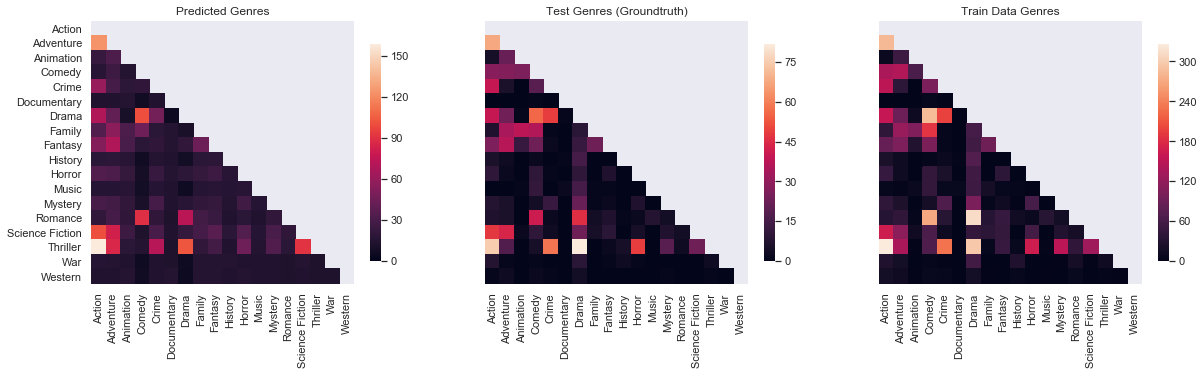

In [129]:
# By count
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 20))
make_heatmap(nr_ids, visGrid_pred, ax=ax1, cbar_size=0.2)
ax1.set_title("Predicted Genres")
make_heatmap(nr_ids, visGrid_gt, ax=ax2, cbar_size=0.2)
ax2.set_title("Test Genres (Groundtruth)")
make_heatmap(nr_ids, visGrid_train, ax=ax3, cbar_size=0.2)
ax3.set_title("Train Data Genres")
plt.show()

In [138]:
df[df.title.str.lower().str.contains("batman")][[
    "title", "release_date", "genres"]]

,title,release_date,genres
9,Batman v Superman: Dawn of Justice,2016-03-23,"[Action, Adventure, Fantasy]"
119,Batman Begins,2005-06-10,"[Action, Crime, Drama]"
210,Batman & Robin,1997-06-20,"[Action, Crime, Fantasy]"
299,Batman Forever,1995-05-31,"[Action, Crime, Fantasy]"
428,Batman Returns,1992-06-19,"[Action, Fantasy]"
1359,Batman,1989-06-23,"[Fantasy, Action]"
3853,"Batman: The Dark Knight Returns, Part 2",2013-01-18,"[Action, Animation]"
4265,Batman,1966-07-30,"[Family, Adventure, Comedy, Science Fiction, C..."


In [139]:
df[df.title.str.lower().str.contains("kung fu panda")][[
    "title", "release_date", "genres"]]

,title,release_date,genres
137,Kung Fu Panda 2,2011-05-25,"[Animation, Family]"
152,Kung Fu Panda 3,2016-01-23,"[Action, Adventure, Animation, Comedy, Family]"
181,Kung Fu Panda,2008-06-04,"[Adventure, Animation, Family, Comedy]"
